## Smart Substitution  — Sprint 1 

#### Objective

Prepare a clean, model-ready dataset from Coles data that is easy for the team to understand and extend. In Sprint 1 we:

**stabilised IDs and tags**,

produced conservative brand features **(brand_clean, brand_confidence, brand_tier)**,

fixed **unit/size** fields,

created a practical **size_band** to keep swaps like-for-like on pack size,

and exported a neat Data file for Sprint-2 modelling.

#### What’s included in the Dataset

product_code, name, category, subcategory, unit_type, price, item_size, price_per_unit, tags, brand_clean, brand_confidence, brand_tier, size_band.

### Contents

1) Environment & config

2) Load data & stabilise IDs/tags

3) Brand enhancement (conservative)

4) Numeric consistency (price, item_size, price_per_unit)

5) Size bands (subcategory × unit_type)

6) Light sanity visuals (optional)

7) Export V4 + quick summary

8) Data dictionary (V4 columns)

9) Limitations & next steps

### 1) Environment & config

Keep paths and toggles in one place so the rest of the notebook stays clean.

In [6]:
### Environment & config

import os, ast, re
import numpy as np
import pandas as pd

# Updating the Dataset
INPUT_PATH  = r"C:\Shazza\T2 2025\Cap Stone B\Sythetics Data Creation_SP_1\Materials\Bailey_df_V2.csv"

# Final Sprint-1 artifact 
EXPORT_DIR  = r"C:\Shazza\T2 2025\Cap Stone B\Sythetics Data Creation_SP_1\Exports"
EXPORT_NAME = "smart_substitution_working_v4_features_neat.csv"

# Optional visuals
SHOW_PLOTS = True
if SHOW_PLOTS:
    import matplotlib.pyplot as plt

print("Pandas:", pd.__version__)


Pandas: 2.2.2


### 2) Load data & stabilise IDs/tags

We iterated a lot; this guarantees product_code stays intact (string) and tags are real lists (not stringified). 

In [8]:
### Load data & stabilise IDs/tags

df = pd.read_csv(INPUT_PATH)

# IDs as strings (prevents float/NaN issues)
if "product_code" in df.columns:
    df["product_code"] = df["product_code"].astype(str).str.strip()

# Parse tags safely
def parse_tags(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str) and x.strip().startswith('[') and x.strip().endswith(']'):
        try:
            v = ast.literal_eval(x)
            if isinstance(v, list):
                return v
        except Exception:
            pass
    if isinstance(x, str) and x.strip():
        return [t.strip() for t in x.replace(";", ",").split(",") if t.strip()]
    return []

df["tags"] = df.get("tags", []).apply(parse_tags)

print("Loaded rows:", len(df))
df.head(3)


Loaded rows: 40377


,product_code,name,category,brand,price,item_size,price_per_unit,unit_type,tags,subcategory
0,8371390,coles hot cross buns traditional fruit,easter,coles,3.0,6.02740,0.73,each,"[coles, cross, buns, fruit]",easter
1,7473849,coles hot cross buns choc chip,easter,coles,3.0,6.02740,0.73,each,"[coles, cross, buns, choc, chip]",easter
2,5726070,coles hot cross buns traditional fruit mini,easter,coles,3.0,8.97959,0.49,each,"[coles, cross, buns, fruit]",easter



DataFrame loaded; product_code is stable; tags are lists ready for similarity features later.

### 3) Brand enhancement (conservative)


We want reliable brand signals without over-claiming (e.g., not tagging “organic” or “fresh” as brands). We:

detect Coles store brand,

capture multi-word brands (exact / optional fuzzy),

allow vetted single-word brands via a small whitelist learned from the data,

fall back to unbranded when uncertain,

and add a brand tier that’s useful for soft preferences.

In [11]:
### Brand enhancement (conservative, richer lexicon)

# Normalise names; keep a raw hint
df = df[~df["name"].isna()].copy()
df["name_norm"] = df["name"].astype(str).str.lower()
df["brand_raw"] = df.get("brand", "").astype(str).str.strip().str.lower()

import re
def _norm(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[^\w\s&']", " ", s)   # keep & and apostrophes for brand phrases
    s = re.sub(r"\s+", " ", s).strip()
    return s

# 1) Store brands (Coles ecosystem)
STORE_BRANDS = {
    "coles","coles finest","coles organic","coles urban coffee culture",
    "coles simply less","coles kitchen","coles bakery","coles brand"
}

# 2) Known multi-word brands (expanded)
KNOWN_MULTIWORD_BRANDS = {
    "red rock deli","head & shoulders","golden circle","uncle tobys","dairy farmers",
    "san remo","masterfoods","ben & jerry's","ben and jerrys","mccain foods","old el paso",
    "green & black's","green and blacks","mount franklin","devondale dairy","bulla dairy",
    "queen baking","continental soups","hoyts herbs","patak's","pataks","capilano honey",
    "saxa salt","arnott's","arnotts","red bull","v energy","sanitarium","pauls dairy",
    "nestle milo","ob finest","two minute noodles","maggi noodles","cadbury dairy milk"
}

STORES_N = {_norm(x) for x in STORE_BRANDS}
KNOWN_N  = {_norm(x) for x in KNOWN_MULTIWORD_BRANDS}

# 3) Non-brand leads (expanded — descriptors, pack words, ingredients, Bailey labels)
NON_BRAND_LEADS = {
    # descriptors/marketing
    "organic","frozen","fresh","premium","natural","australian","classic","original","value","bulk",
    "light","lite","low","reduced","no","free","gluten","vegan","vegetarian","dairy","lactose","sugar",
    "baby","men","women","kids","adult","mini","large","extra","family","instant","iced","dry","wet",
    "sweet","savoury","spicy","mild","hot","cold","creamy","soft","crunchy","deluxe","ultimate",
    "sensitive","whitening","advanced","daily","traditional","authentic","genuine","true","signature",
    # packaging / forms / quantities
    "pack","packet","pk","carton","box","bag","bottle","jar","tin","can","pouch","wrap","roll","sleeve",
    "bundle","case","tray","tub","cup","bar","stick","slice","sachet","packaging",
    "small","medium","large","xl","xxl","jumbo","single","multi","assorted","variety","mix","selection",
    "twin","triple","six","dozen",
    # common foods/ingredients
    "orange","apple","banana","strawberry","vanilla","chocolate","mango","grape","grapes","lemon","lime",
    "berry","berries","blueberry","raspberry","peach","apricot","pear","plum","coconut","peanut","almond",
    "cashew","walnut","hazelnut","pistachio","macadamia",
    "chicken","beef","pork","lamb","turkey","ham","bacon","fish","seafood","tuna","salmon","sardines",
    "mackerel","prawn","shrimp","crab","lobster","oyster","mussel",
    # staples/categories
    "milk","cream","butter","cheese","yoghurt","yogurt","bread","roll","muffin","loaf","bun","cake",
    "biscuit","biscuits","cookie","cookies","cracker","crackers","chips","cereal","muesli","granola",
    "jam","marmalade","honey","oil","olive","vinegar","salt","pepper","sugar","flour","pasta","noodle",
    "spaghetti","penne","macaroni","fettuccine","rice","water","juice","cordial","drink","drinks",
    "dessert","ice","cream","icecream","spread","spreads","dip","dips","snack","snacks","gum","mints",
    "mint","wine","pinot","rosé","rose","shiraz","merlot","chardonnay",
    # personal care / pet / home
    "shampoo","conditioner","soap","body","wash","deodorant","deo","toothpaste","toothbrush","mouthwash",
    "serum","moisturiser","moisturizer","cleanser","toner","mask","sunscreen","lotion","balm",
    "razor","blade","wipes","wipe","nappy","diaper","dog","cat","pet","laundry","kitchen","homewares",
    "aircare","cleaning","bleach","detergent",
    # Some of  Bailey category labels 
    "hair","hair care","skin","skin care","medicinal","medicinal products","vitamins","health","health foods",
    "confectionery","biscuits & cookies","asian foods","coffee","snacks","cosmetics/toiletries",
    "mens deos & grooming","chilled desserts","wine","dental health","cleaning goods","ice cream",
    "protein & meals","cereal","softdrinks","sanitary protection","soaps & body wash","baking mixes",
    "womens deos & groom","cheese dairy","infant food","bars gum pocket pack","tea","meals",
    "spices/herbs","meal bases","juices & cordials","dy milk","dry milk","nutritional snacks","soup",
    "spreads","sauces/relish","pet food","infant personal","indian foods","canned fish","spirits",
    "dog food","laundry accessories","frozen snacks","cat food","juices/drinks","laundry","instore bread"
}

# 4) Build a whitelist of real single-word brands from the data (plus a few manual boosts)
vc = df["brand_raw"].fillna("").str.strip().str.lower().value_counts()
KNOWN_SINGLE_WORD_BRANDS = {
    b for b, c in vc.items()
    if b and (" " not in b) and b not in NON_BRAND_LEADS and b not in {"unbranded"} and c >= 25
}
KNOWN_SINGLE_WORD_BRANDS |= {
    "cadbury","arnotts","nestle","mccain","devondale","bulla","saxa","hoyts",
    "pataks","pauls","sanitarium","coles"
}

# Optional fuzzy support
try:
    from rapidfuzz import process, fuzz
    HAVE_RAPIDFUZZ = True
except Exception:
    HAVE_RAPIDFUZZ = False

def _ngrams(tokens, n):
    return [" ".join(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

def candidate_ngrams(text: str, max_n: int = 4) -> set:
    toks = _norm(text).split()
    cands = set()
    for n in range(2, max_n + 1):
        cands.update(_ngrams(toks, n))
    return cands

def fuzzy_best_match(candidates: set, choices: list, score_cutoff: int = 90):
    if not HAVE_RAPIDFUZZ or not candidates:
        return None, 0
    context = " ".join(sorted(candidates))
    match = process.extractOne(context, choices, scorer=fuzz.token_set_ratio, score_cutoff=score_cutoff)
    return (match[0], match[1]) if match else (None, 0)

def extract_brand_and_reason(name: str, brand_raw: str):
    name_n = _norm(name)
    brand_raw_n = _norm(brand_raw)

    # 1) Store brand detection
    for sb in STORES_N:
        if name_n.startswith(sb + " ") or brand_raw_n == sb:
            return "coles", "store_brand"

    # 2) Exact multi-word brand from name
    cands = candidate_ngrams(name_n, max_n=4)
    inter = cands & KNOWN_N
    if inter:
        return max(inter, key=len), "multiword_exact"

    # 3) Fuzzy multi-word 
    match, score = fuzzy_best_match(cands, list(KNOWN_N), score_cutoff=90)
    if match:
        return match, "multiword_fuzzy"

    # 4) Single-word brand from brand_raw (whitelisted)
    if brand_raw_n in KNOWN_SINGLE_WORD_BRANDS:
        return brand_raw_n, "singleword_whitelist(raw)"

    # 5) First token of name (whitelisted)
    first = name_n.split()[0] if name_n else ""
    if first in KNOWN_SINGLE_WORD_BRANDS:
        return first, "singleword_whitelist(first)"

    # 6) Fall back
    return "unbranded", "none"

# Apply extractor
res = df.apply(lambda r: extract_brand_and_reason(r["name_norm"], r["brand_raw"]), axis=1)
df[["brand_clean","brand_confidence"]] = pd.DataFrame(res.tolist(), index=df.index)

def to_tier(b):
    if b == "coles": return "store"
    if b == "unbranded": return "unbranded"
    return "branded"
df["brand_tier"] = df["brand_clean"].apply(to_tier)


Added: brand_clean, brand_confidence, brand_tier. The distribution plot helps catch obvious mislabelling (e.g., store brand too low or everything “unbranded”).

### 4) Numeric consistency (price, item_size, price_per_unit)


To build size_band and compare fairly, item_size and price_per_unit must be present and sane. For g/ml we can infer size from price/ppu; for each we default to 1.

In [14]:
### Numeric consistency

for c in ["price", "item_size", "price_per_unit"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Recompute item_size for g/ml if missing/≤0 and PPU available
need_size = df["unit_type"].isin(["g","ml"]) & (df["item_size"].isna() | (df["item_size"]<=0))
df.loc[need_size, "item_size"] = df.loc[need_size, "price"] / df.loc[need_size, "price_per_unit"]

# For 'each', default to 1 when missing (pack parsing is out of scope here)
need_each = (df["unit_type"] == "each") & (df["item_size"].isna() | (df["item_size"]<=0))
df.loc[need_each, "item_size"] = 1

# Compute missing PPU if possible
need_ppu = df["price_per_unit"].isna() & df["price"].notna() & df["item_size"].notna() & (df["item_size"]>0)
df.loc[need_ppu, "price_per_unit"] = df.loc[need_ppu, "price"] / df.loc[need_ppu, "item_size"]

# Clean impossible/inf
df["price_per_unit"] = df["price_per_unit"].replace([np.inf, -np.inf], np.nan)
df.loc[df["price_per_unit"]<=0, "price_per_unit"] = np.nan

df[["unit_type","price","item_size","price_per_unit"]].head(6)


,unit_type,price,item_size,price_per_unit
0,each,3.0,6.02740,0.7300
1,each,3.0,6.02740,0.7300
2,each,3.0,8.97959,0.4900
3,g,8.0,306.51341,0.0261
4,g,6.7,113.94558,0.0588
5,each,3.0,6.02740,0.7300


Output summary
Numerics are consistent; item_size is filled for g/ml and set to 1 for each when missing; price_per_unit is present where calculable.

### 5) Size bands (subcategory × unit_type)

Encourage like-sized swaps: small/medium/large for g/ml groups that have enough size variety; otherwise mixed (including each).

C:\Users\mrsha\AppData\Local\Temp\ipykernel_19804\1202391463.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["size_band"] = df.groupby(grp, group_keys=False).apply(size_band_group)


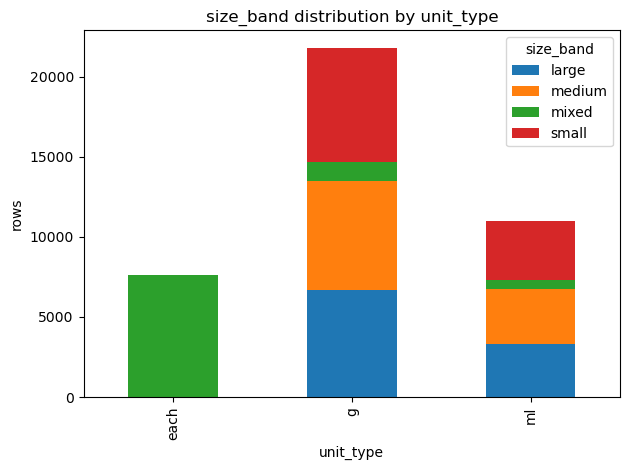

In [17]:
# 5) Size bands
if "subcategory" not in df.columns:
    raise ValueError("Missing 'subcategory' column — needed for grouping size bands.")

grp = ["unit_type","subcategory"]

def size_band_group(g):
    # Only band g/ml; 'each' stays 'mixed' in Sprint-1
    if g["unit_type"].iloc[0] not in ("g","ml"):
        return pd.Series(["mixed"]*len(g), index=g.index)
    # Need enough items & size variety
    if g["item_size"].nunique(dropna=True) < 3 or len(g) < 30:
        return pd.Series(["mixed"]*len(g), index=g.index)
    try:
        bands = pd.qcut(g["item_size"], q=3, labels=["small","medium","large"], duplicates="drop")
        return bands.astype(object).where(~bands.isna(), "mixed")
    except Exception:
        return pd.Series(["mixed"]*len(g), index=g.index)

df["size_band"] = df.groupby(grp, group_keys=False).apply(size_band_group)

# Optional glance: size_band counts by unit_type
if SHOW_PLOTS:
    sb = (df.groupby("unit_type")["size_band"]
            .value_counts()
            .rename("n")
            .reset_index())
    pivot = sb.pivot(index="unit_type", columns="size_band", values="n").fillna(0)
    pivot.plot(kind="bar", stacked=True)
    plt.title("size_band distribution by unit_type")
    plt.xlabel("unit_type")
    plt.ylabel("rows")
    plt.tight_layout()
    plt.show()


New column: size_band ∈ {small, medium, large, mixed} with sensible fallbacks

### 6) Light sanity visuals

Just enough to spot gross issues (ranges by unit type; size_band coverage).

C:\Users\mrsha\AppData\Local\Temp\ipykernel_19804\3032375406.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


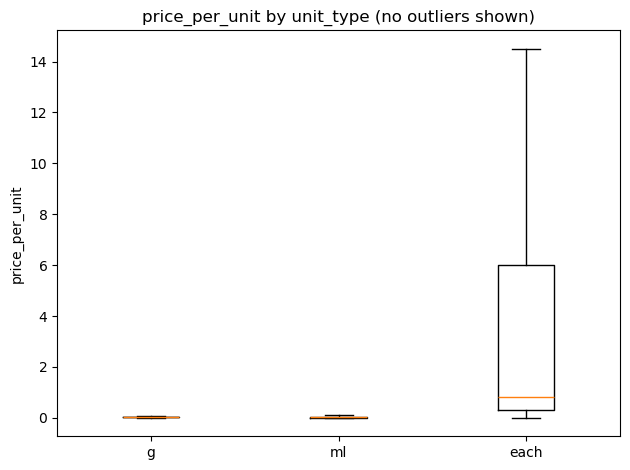

In [20]:
### Light sanity visuals 

if SHOW_PLOTS:
    # Boxplot of PPU by unit_type (without extreme fliers)
    plt.figure()
    data = [df.loc[df["unit_type"]==u, "price_per_unit"].dropna().values for u in ["g","ml","each"]]
    labels = ["g","ml","each"]
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.title("price_per_unit by unit_type (no outliers shown)")
    plt.ylabel("price_per_unit")
    plt.tight_layout()
    plt.show()


From this Plot We can See that

-> g and ml have very tight, low ranges (medians near zero on this scale), which is expected because *$/g*  and  *$/ml* are small numbers and fairly consistent within categories.

_> each shows a much higher median and huge spread — per-item pricing mixes cheap items (e.g., single rolls) with expensive ones (e.g., appliances), so variance explodes.

-> This confirms we shouldn’t compare across unit types; always evaluate substitutions within the same unit_type.

### 7) Export V4 + quick summary


Single export at the end, with a readable column order that prioritises the features we actually use.

In [23]:
### Export V4 + quick summary

# Drop helper column used for parsing
v4 = df.drop(columns=[c for c in ["name_norm"] if c in df.columns], errors="ignore")

# Present key columns first (don’t drop others)
front = [
    "product_code","name","category","subcategory","unit_type",
    "price","item_size","price_per_unit",
    "tags","brand_clean","brand_confidence","brand_tier","size_band"
]
ordered = [c for c in front if c in v4.columns] + [c for c in v4.columns if c not in front]
v4 = v4[ordered]

os.makedirs(EXPORT_DIR, exist_ok=True)
out_path = os.path.join(EXPORT_DIR, EXPORT_NAME)
v4.to_csv(out_path, index=False, encoding="utf-8")

print("Saved V4 to:", out_path)
print("Rows:", len(v4), "| Cols:", len(v4.columns))
v4.head(5)

PermissionError: [Errno 13] Permission denied: 'C:\\Shazza\\T2 2025\\Cap Stone B\\Sythetics Data Creation_SP_1\\Exports\\smart_substitution_working_v4_features_neat.csv'

Output summary
Exported smart_substitution_working_v4_features_neat.csv with model-ready columns only.

### 8) Data dictionary (V4 columns)
What each column means

**-> product_code** — stable SKU identifier (string).

**-> name** — product display name.

**-> category / subcategory** — broad/fine buckets for like-for-like swaps.

**-> unit_type** — unit family: g, ml, each.

**-> price** — pack price (AUD).

**-> item_size** — total grams/ml for g/ml, or item count for each (default 1 if unknown).

**-> price_per_unit** — price / item_size in units of unit_type.

**-> tags** — descriptive tokens (list) used for similarity later.

**-> brand_clean** — conservative brand label (coles, vetted brand, or unbranded).

**-> brand_confidence** — short reason the extractor chose that label (e.g., store_brand, multiword_exact).

**-> brand_tier** — store / branded / unbranded (soft preference signal).

**-> size_band** — small/medium/large for g/ml groups with variety; mixed otherwise.

### 9) Limitations & next steps

#### **Limitations** 

Brand recall is intentionally conservative; some real brands remain unbranded.

Each packs: we don’t parse explicit pack counts yet; we default to 1 when missing.

Outliers are only inspected visually (no trimming).

Value ranks are excluded from this Final Dataset to keep it lean (can be re-introduced for scoring in Sprint-2).

#### **Next steps ideas.**

Expand brand lexicon (grow multi-word list + whitelist from new data).

Parse common pack patterns for each (e.g., “6 pack”, “12 rolls”).

Re-introduce value_percentile (or value_index) when we move to ranking/ML.

Add a small outlier-filter per (subcategory, unit_type) with an audit report.